# Normalizing Flows

![Status](https://img.shields.io/static/v1.svg?label=Status&message=WIP&color=orange)

**Author:** Julius Cathalina

**Last Updated (dd-mm-yyyy):** 29-01-2025

In [1]:
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

In [2]:
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F
try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq

In [3]:
from typing import Callable

In [4]:
L.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


/app/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
def LV(x: float, y: float) -> np.ndarray:
  return np.array([x - x*y, x*y - y])

def rk4(f: Callable[[float, float], np.ndarray], x0: float, y0: float, h: float, n: int) -> tuple[np.ndarray, np.ndarray]:

    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0
    y = y0
    for i in range(1, n + 1):
        k1 = h*f(x, y)
        k2 = h*f(x + 0.5*k1[0], y + 0.5*k1[1])
        k3 = h*f(x + 0.5*k2[0], y + 0.5*k2[1])
        k4 = h*f(x + k3[0], y + k3[1])
        v[i] =  v[i-1] + (k1 + k2 + k2 + k3 + k3 + k4)/6
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def euler(f: Callable[[float, float], np.ndarray], x0: float, y0: float, h: float, n: int) -> tuple[np.ndarray, np.ndarray]:

    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0
    y = y0

    for i in range(1, n + 1):
        v[i] =  v[i-1] + h*f(x, y)
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, h):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    ax0.plot(t_euler, v_euler, marker = 'x')
    ax1.plot(t_rk4, v_rk4, marker = 'x')

    ax0.plot(t_true, v_true)
    ax1.plot(t_true, v_true)

    ax0.set_ylim(0, 3.5)
    ax1.set_ylim(0, 3.5)

    ax0.set_xlabel(r"t", fontsize=25)
    ax0.set_title("Euler, $h=$"+h, fontsize=25)
    ax0.legend(["x Euler", "y Euler", "x True", "y True"])
    ax1.set_xlabel(r"$t$", fontsize=25)
    ax1.set_title("RK4, $h=$"+h, fontsize=25)
    ax1.legend(["x RK4", "y RK4", "x True", "y True"])

    return fig, ax0, ax1

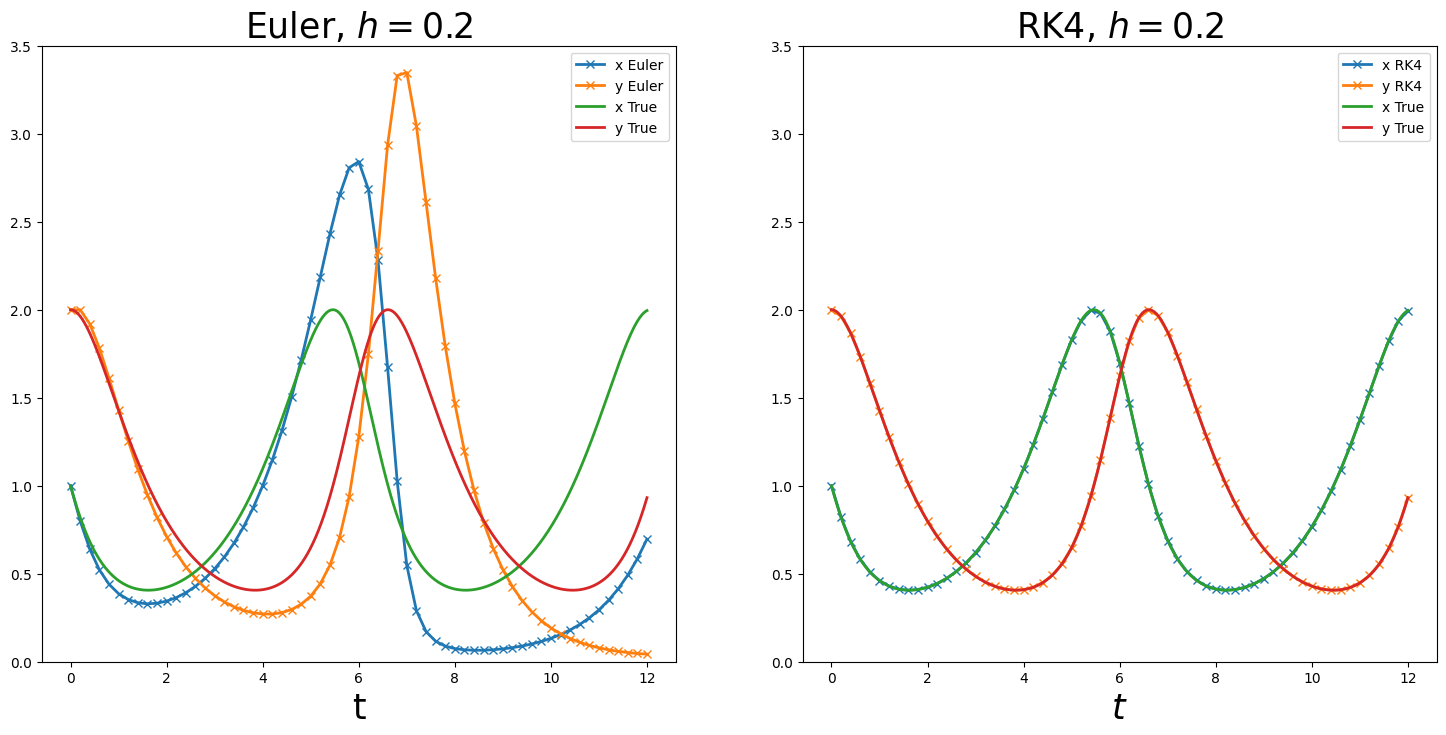

In [7]:
h = 0.2

t_euler, v_euler = euler(LV, 1., 2., h, 60)
t_rk4, v_rk4 = rk4(LV, 1., 2., h, 60)
t_true, v_true = rk4(LV, 1., 2., 0.003, 4000)

fig, ax0, ax1 = plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, str(h))

In [8]:
t, v = euler(LV, 1, 2, 3e-3, 4_000)

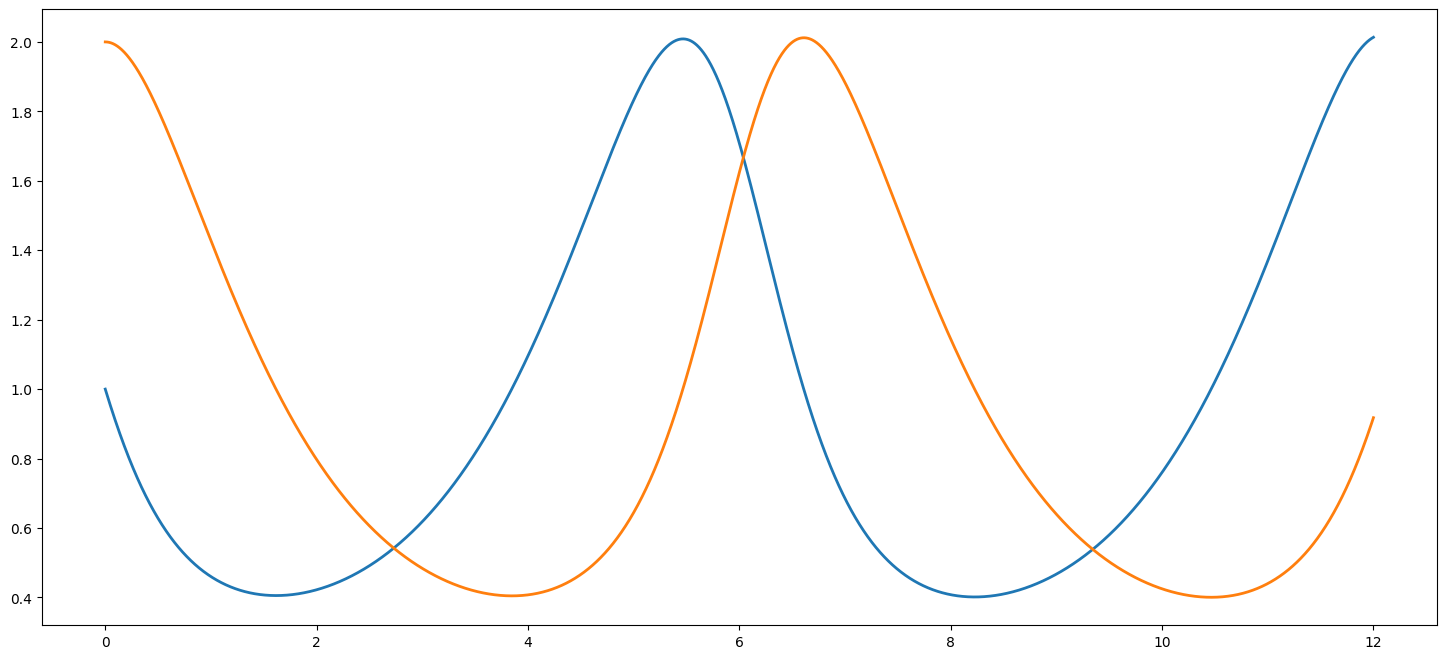

In [9]:
%matplotlib inline
f = plt.figure(figsize=(18, 8))
plt.plot(t, v)

In [10]:
# Delete everything below

In [11]:
from scipy.integrate import odeint

In [12]:
def f(x, t, theta):
    return theta[0] * x + theta[1]

In [13]:
def L(x):
    return 0.5 * np.sum(x**2)

In [14]:
def forward(x0, t, theta):
    solution = odeint(lambda x, t: f(x, t, theta), x0, t)
    return solution

In [15]:
a = forward(x0=np.array([1.0]), t=np.linspace(0,1,100), theta=np.array([2.0, 0.5]))

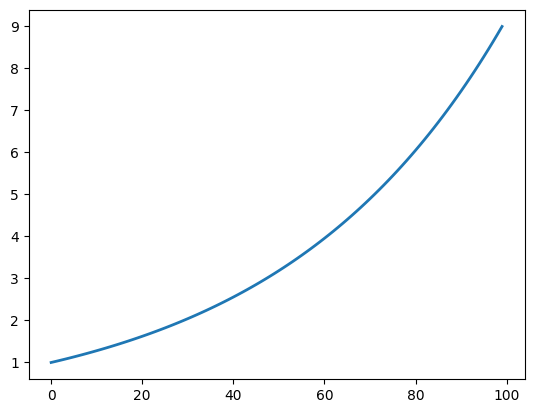

In [16]:
plt.plot(a)

In [28]:
# Now for the adjoint method
def adjoint_dynamics(adj_state, t, x_t, theta):
    """The adjoint ODE that propagates gradients backward
    adj_state contains: [adjoint, gradients w.r.t theta]
    """
    a = adj_state[0]  # The adjoint variable
    
    # Compute partial derivatives
    df_dx = theta[0]  # ∂f/∂x
    df_dtheta = np.array([x_t, 1.0])  # ∂f/∂θ
    
    # Adjoint dynamics: da/dt = -a * ∂f/∂x
    dadx = -a * df_dx
    
    # Gradient dynamics: dg/dt = -a * ∂f/∂θ
    dgdtheta = -a * df_dtheta
    
    return np.concatenate([[dadx], dgdtheta])

In [37]:
import numpy as np
from scipy.integrate import odeint

def f(x, t, theta):
    """ODE function dx/dt = f(x,t,theta)
    x: state vector (scalar in this case)
    theta: parameters [slope, bias]
    Returns: scalar value representing rate of change
    """
    return theta[0] * x + theta[1]

def forward(x0, t, theta):
    """Solve ODE forward in time
    Returns: array of x values at each time point
    """
    solution = odeint(lambda x, t: f(x, t, theta), x0, t)
    return solution

def adjoint_dynamics_corrected(adj_state, t, x_t, theta):
    a = adj_state[0]
    
    # The key insight is that θ₁ affects both the direct sensitivity
    # and how the adjoint variable propagates
    df_dx = theta[0]
    df_dtheta1 = x_t
    df_dtheta2 = 1.0
    
    # The adjoint equation needs to account for how θ₁ affects
    # the entire trajectory through the state derivative
    da_dt = -a * df_dx
    dgrad_theta1 = -a * df_dtheta1
    dgrad_theta2 = -a * df_dtheta2
    
    return np.array([da_dt, dgrad_theta1, dgrad_theta2])

def compute_gradient(x0, t, theta):
    """Compute gradients of loss with respect to theta using adjoint method"""
    # Forward pass
    x_trajectory = forward(x0, t, theta)
    final_x = x_trajectory[-1, 0]  # Get final scalar value
    
    # Initialize adjoint state
    # [adjoint, grad_theta1, grad_theta2]
    adj_state = np.array([final_x, 0.0, 0.0])  
    
    # Solve adjoint ODE backward in time
    t_backward = np.flip(t)
    
    # Create a function that looks up x value at the correct time
    def get_x_at_time(t):
        return np.interp(t, t_backward, x_trajectory[::-1, 0])
    
    # Solve adjoint system
    adj_solution = odeint(
        lambda a, t: adjoint_dynamics(a, t, get_x_at_time(t), theta),
        adj_state,
        t_backward
    )
    
    # Extract final gradients
    final_gradients = adj_solution[-1, 1:]
    return final_gradients

# Example usage
x0 = np.array([1.0])
t = np.linspace(0, 1, 100)
theta = np.array([2.0, 0.5])

gradients = compute_gradient(x0, t, theta)
print(f"Gradients with respect to theta: {gradients}")

Gradients with respect to theta: [28.7070544  28.70705436]


In [38]:
# Verify with finite differences
def compute_finite_diff(x0, t, theta, eps=1e-5):
    # Compute loss at original theta
    x_orig = forward(x0, t, theta)[-1, 0]
    loss_orig = 0.5 * x_orig**2
    
    gradients = []
    for i in range(len(theta)):
        theta_plus = theta.copy()
        theta_plus[i] += eps
        x_plus = forward(x0, t, theta_plus)[-1, 0]
        loss_plus = 0.5 * x_plus**2
        
        grad = (loss_plus - loss_orig) / eps
        gradients.append(grad)
    
    return np.array(gradients)

# Compare gradients
adj_grads = compute_gradient(x0, t, theta)
fin_grads = compute_finite_diff(x0, t, theta)
print("Adjoint gradients:", adj_grads)
print("Finite difference gradients:", fin_grads)

Adjoint gradients: [28.7070544  28.70705436]
Finite difference gradients: [75.82451199 28.7070915 ]


In [57]:
A = np.zeros(shape=(3,1)); B = np.zeros((1,3))

In [58]:
(A@B).shape

(3, 3)

In [62]:
np.zeros((3,))

array([0., 0., 0.])

In [60]:
np.zeros((3,1))

array([[0.],
       [0.],
       [0.]])

In [73]:
C = np.array([
    [1, 2],
    [3, 4]
])
C

array([[1, 2],
       [3, 4]])

In [75]:
C_prime = np.array([
    [4, -2],
    [-3, 1]
])
C_prime

array([[ 4, -2],
       [-3,  1]])

In [76]:
C@C_prime

array([[-2,  0],
       [ 0, -2]])

In [83]:
C_inv = (1/((1*4)-(2*3)))* C_prime

In [84]:
C_inv 

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [87]:
C @ C_inv

array([[1., 0.],
       [0., 1.]])

In [89]:
A = np.array([
    [1, 2, 1],
    [4, 4, 5],
    [6, 7, 7]
])
A

array([[1, 2, 1],
       [4, 4, 5],
       [6, 7, 7]])

In [90]:
B = np.array([
    [-7, -7, 6],
    [2, 1, -1],
    [4, 5, -4]
])
B

array([[-7, -7,  6],
       [ 2,  1, -1],
       [ 4,  5, -4]])

In [95]:
assert np.allclose(A@B, B@A), "Not invertible bro"
A@B

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [101]:
np.linalg.det(C_inv)

np.float64(-0.5)

In [110]:
2 * np.linalg.trace(A)

np.int64(24)